<a href="https://colab.research.google.com/github/tahamsi/computer-vision/blob/main/week-9/Vidoe_Segmentation_with_SAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/tahamsi/computer-vision)

# Image Segmentation with Segment Anything Model v2 (SAM 2)



[Segment Anything Model 2](https://github.com/facebookresearch/sam2?tab=readme-ov-file) (SAM 2) is a foundation model designed for promptable visual segmentation in both images and videos. To extend SAM's capabilities to video, individual images are treated as single-frame videos. The model utilizes a streamlined transformer architecture with a streaming memory component to enable real-time video processing. Trained on a large, diverse dataset, SAM 2 demonstrates strong performance across various tasks and visual domains.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-2-paper.jpg)

##Promptable Visial Segmentation
Promptable visual segmentation is a technique where a segmentation model, such as SAM 2, is guided by prompts to identify and segment specific parts of an image or video. Prompts can be various types of inputs, such as:

* Points: Locations in the image that indicate the starting position or an object to be segmented.
* Boxes: Bounding boxes around objects, helping the model understand the region of interest.
* Masks: Roughly defined regions, which the model can refine into more accurate segmentations.
* Text Prompts: In some models, text descriptions guide the segmentation to certain types of objects (e.g., “segment the dog” in an image with multiple animals).

The benefit of promptable segmentation is flexibility; users can direct the model to focus on specific areas or types of objects without pre-defined categories, making it adaptable for various tasks and contexts.



### Before you start

Let's ensure you have `GPU` access by using the `nvidia-smi` command to check. If there are any issues, go to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. The codes here are extended from [Meta AI](https://github.com/facebookresearch/sam2?tab=readme-ov-file) and [Roboflow](https://github.com/roboflow/notebooks).

In [ ]:
!nvidia-smi

Sat Nov  9 18:40:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install SAM2

In [1]:
import os
HOME = os.getcwd()
!git clone https://github.com/facebookresearch/sam2.git
%cd sam2
!pip install -e .

Cloning into 'sam2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 974 (delta 17), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (974/974), 128.94 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (334/334), done.
Updating files: 100% (566/566), done.
/content/sam2
Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -q supervision[assets] jupyter_bbox_widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.2 MB/s eta 0:00:00


### Download checkpoints

SAM2 is available in four model sizes, ranging from the lightweight `sam2_hiera_tiny` with 38.9 million parameters to the more powerful `sam2_hiera_large` with 224.4 million parameters.

In [3]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Imports

In [7]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

This code enables `mixed-precision` computing to accelerate deep learning. It primarily uses bfloat16 for calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for specific operations to enhance performance further.

In [5]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Load model





In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Preprocess video

### Download video and split it into frames

SAM2 assumes that the video is stored as a series of `JPEG` frames with filenames formatted as `<frame_index>.jpg`. To get started, let’s download a sample video, split it into frames, and save them to disk. You can replace `SOURCE_VIDEO` with the path to your own video file.

In [10]:
SOURCE_VIDEO = download_assets(VideoAssets.BASKETBALL)
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

  0%|          | 0/27178650 [00:00<?, ?it/s]

VideoInfo(width=1920, height=1080, fps=59, total_frames=477)

To reduce VRAM usage, there are three additional parameters: `SCALE_FACTOR` to lower the frame resolution, and `START_IDX` and `END_IDX` to extract only specific segments of the video.

In [ ]:
SCALE_FACTOR = 0.5
START_IDX = 100
END_IDX = 300

In [ ]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, which means you need to initialize an inference state for this video. During initialization, SAM 2 loads all JPEG frames from `video_path` and stores their pixel data in `inference_state`, as indicated in the progress bar below.

In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

If you have used this `inference_state` for any previous tracking, please reset it first using reset_state. (The cell below is for illustration only; there’s no need to call `reset_state` here, as this `inference_state` has just been freshly initialized above.)

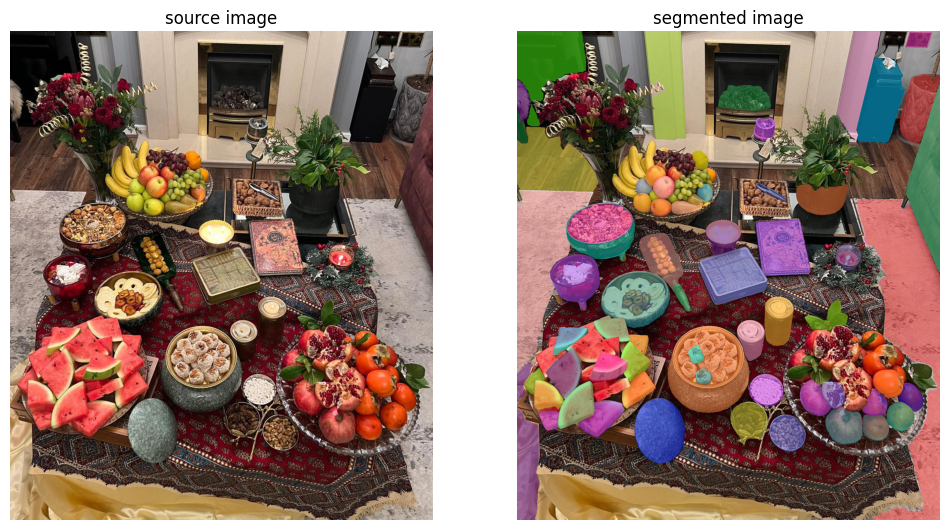

In [ ]:
sam2_model.reset_state(inference_state)

## Prompting with points

Execute cell below and use your mouse to **draw points** on the image.

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

SAM2 supports tracking multiple objects simultaneously. To adjust the list of tracked objects, simply update the `OBJECTS` list.

In [ ]:
OBJECTS = ['ball', 'player-1', 'player-2']

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

Select the index of the reference frame that will be used to annotate the objects of interest.

In [ ]:
FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

[{'x': 205, 'y': 670, 'width': 0, 'height': 0, 'label': ''},
 {'x': 636, 'y': 566, 'width': 0, 'height': 0, 'label': ''}]

The widget you’re using stores annotations in a format that doesn’t align with SAM2's requirements. To address this, you can parse the annotations and pass them to SAM2 using the `add_new_points` method. Each object being tracked requires a separate `add_new_points` call. It’s essential to specify `frame_idx` each time —the index of the frame the annotations refer to— and `obj_id`, the ID of the object associated with the annotations.

In [ ]:
default_box = [
    {'x': 705, 'y': 302, 'width': 0, 'height': 0, 'label': 'ball'},
    {'x': 587, 'y': 300, 'width': 0, 'height': 0, 'label': 'player-1'},
    {'x': 753, 'y': 267, 'width': 0, 'height': 0, 'label': 'player-2'}
]

boxes = widget.bboxes if widget.bboxes else default_box

for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

### Video inference

**NOTE:** To apply the point prompts to all video frames, use the `propagate_in_video` generator. Each call returns `frame_idx` - the index of the current frame, `object_ids` - IDs of objects detected in the frame, and `mask_logits` - corresponding `object_ids` logit values, which you can convert to masks using thresholding.

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

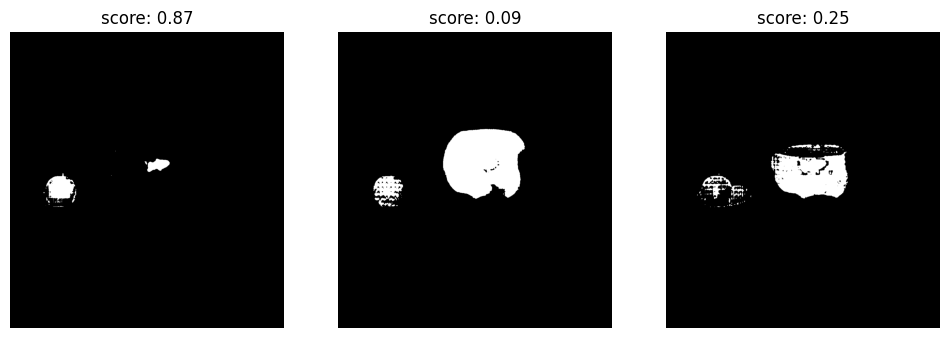

In [ ]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)